# Регрессия для IC50

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna

In [3]:
df_clean = pd.read_csv("df_cleaned.csv")
df_clean.head(5)

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,2,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_clean.shape

(980, 196)

In [5]:
X = df_clean.drop(['IC50, mM', 'SI', 'CC50, mM', 'Unnamed: 0'], axis=1)  
y = df_clean['IC50, mM']

In [6]:
# Добавляем целевую переменную в DataFrame
X_with_target = X.copy()
X_with_target["target"] = y

# Вычисляем корреляционную матрицу
corr_matrix = X_with_target.corr(numeric_only=True)
target_corr = corr_matrix["target"].drop("target").sort_values(key=np.abs, ascending=False)

selected_cols = target_corr.head(10).index.tolist()

print("\nТоп-10 признаков по модулю корреляции с целевой переменной:")
print(target_corr.head(10))

# Генерация полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_with_target[selected_cols])
poly_feature_names = poly.get_feature_names_out(selected_cols)

df_poly = pd.DataFrame(X_poly, columns=poly_feature_names, index=X_with_target.index)

# Отбираем только новые признаки (исключаем исходные)
new_poly_features = [f for f in poly_feature_names if f not in selected_cols]
df_poly_new_only = df_poly[new_poly_features]  # ← эта строка была пропущена

# Добавляем целевую переменную
df_poly_with_target = df_poly_new_only.copy()
df_poly_with_target['target'] = y

# Вычисляем корреляцию с целевой переменной
corr_matrix = df_poly_with_target.corr(numeric_only=True)
corr_target = corr_matrix['target'].drop('target')

# Топ-20 новых признаков по модулю корреляции
top_20 = corr_target.abs().sort_values(ascending=False).head(20)

print("Топ-20 новых полиномиальных признаков по корреляции с целевой переменной:")
print(top_20)



Топ-10 признаков по модулю корреляции с целевой переменной:
VSA_EState4    -0.277346
fr_nitro        0.261613
Chi2n          -0.259928
PEOE_VSA7      -0.258582
fr_Nhpyrrole    0.251986
fr_Ar_NH        0.251986
Chi2v          -0.250932
Chi4v          -0.247722
Chi4n          -0.247521
Chi3n          -0.242723
Name: target, dtype: float64
Топ-20 новых полиномиальных признаков по корреляции с целевой переменной:
fr_nitro fr_Nhpyrrole    0.414983
fr_nitro fr_Ar_NH        0.414983
VSA_EState4 fr_nitro     0.317588
fr_nitro^2               0.261613
fr_Ar_NH^2               0.251986
fr_Nhpyrrole^2           0.251986
fr_Nhpyrrole fr_Ar_NH    0.251986
VSA_EState4 Chi2v        0.230966
VSA_EState4 Chi2n        0.229980
VSA_EState4 Chi4v        0.225399
VSA_EState4 Chi4n        0.224423
VSA_EState4 Chi3n        0.222733
PEOE_VSA7 Chi2v          0.212331
Chi2n PEOE_VSA7          0.209329
PEOE_VSA7 Chi4v          0.208155
Chi2n Chi2v              0.205365
Chi2v^2                  0.205329
Chi2v Ch

In [7]:
# Добавляем отобранные признаки в основной датафрейм
top_20_poly_features = top_20.index.tolist()
df_extended = pd.concat([X, df_poly[top_20_poly_features]], axis=1)
print(f"Новый размер датафрейма: {df_extended.shape}")

Новый размер датафрейма: (980, 212)


In [8]:
# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_extended)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42)

# Обучение Lasso с кросс-валидацией для автоматического выбора alpha
lasso = LassoCV(cv=5, random_state=42, max_iter=50_000, tol=1e-3)
lasso.fit(X_train, y_train)

# Выводим коэффициенты
coef = pd.Series(lasso.coef_, index=df_extended.columns)
print("Коэффициенты Lasso:")
print(coef)

# Отбор признаков: только те, у которых коэффициент ≠ 0
selector = SelectFromModel(lasso, prefit=True)
selected_features = df_extended.columns[selector.get_support()]
X_selected_df = pd.DataFrame(df_extended, columns=selected_features)

# Показать отобранные признаки
selected_features = df_extended.columns[selector.get_support()]
print("\nВыбранные признаки:")
print(selected_features.shape)

Коэффициенты Lasso:
MaxAbsEStateIndex     0.000000
MaxEStateIndex        0.000000
MinAbsEStateIndex   -54.700460
MinEStateIndex       -0.000000
qed                  -3.007707
                       ...    
Chi2n Chi2v           0.000000
Chi2v^2               0.000000
Chi2v Chi4v           0.000000
Chi2n Chi4v           0.000000
PEOE_VSA7 Chi4n       0.000000
Length: 212, dtype: float64

Выбранные признаки:
(95,)


(980, 95)


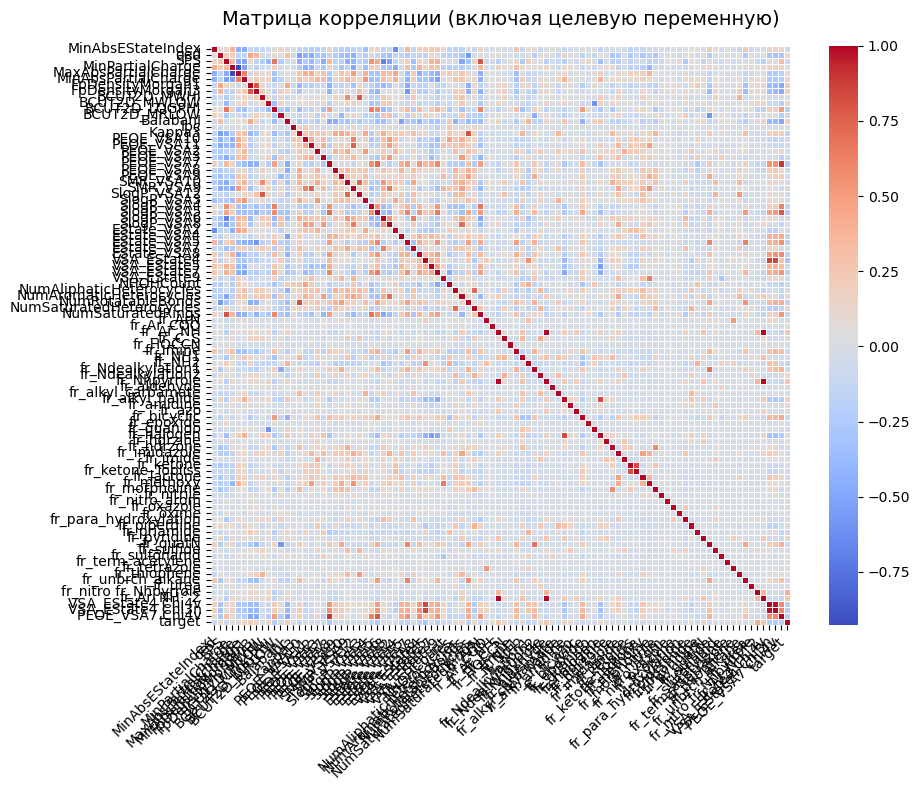


Топ-10 признаков по модулю корреляции с целевой переменной:
fr_nitro fr_Nhpyrrole    0.414983
VSA_EState4             -0.277346
PEOE_VSA7               -0.258582
fr_Ar_NH                 0.251986
fr_Ar_NH^2               0.251986
fr_Nhpyrrole             0.251986
SlogP_VSA5              -0.239361
VSA_EState4 Chi4v       -0.225399
VSA_EState4 Chi3n       -0.222733
BCUT2D_LOGPHI           -0.212648
Name: target, dtype: float64


In [9]:
# Создаем DataFrame из отобранных признаков
print(X_selected_df.shape)

# Добавляем целевую переменную в DataFrame
X_with_target = X_selected_df.copy()
X_with_target["target"] = y

# Вычисляем корреляционную матрицу
corr_matrix = X_with_target.corr(numeric_only=True)

# Визуализация матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    xticklabels=True,
    yticklabels=True
)
plt.xticks(rotation=45, ha='right')
plt.title('Матрица корреляции (включая целевую переменную)', fontsize=14, pad=15)
plt.tight_layout()
plt.show()

# Топ-10 признаков по корреляции с целевой переменной
target_corr = corr_matrix["target"].drop("target").sort_values(key=np.abs, ascending=False)

print("\nТоп-10 признаков по модулю корреляции с целевой переменной:")
print(target_corr.head(10))


In [10]:
base_models = {
    "LinearRegression": LinearRegression(),
    "RandomForest":     RandomForestRegressor(random_state=42),
    "ExtraTrees":       ExtraTreesRegressor(random_state=42),
    "HistGBR":          HistGradientBoostingRegressor(random_state=42),
    "XGBoost":          XGBRegressor(random_state=42, verbosity=0),
    "LightGBM":         LGBMRegressor(random_state=42),
    "CatBoost":         CatBoostRegressor(random_state=42, verbose=0)
}

# Оборачиваем каждую модель в Pipeline со StandardScaler
models = {
    name: Pipeline([
        ("scaler", StandardScaler()),
        ("model", mdl)
    ])
    for name, mdl in base_models.items()
}

# Кросс-валидация и сбор результатов
CV = KFold(n_splits=5, shuffle=True, random_state=42)
SCORER = make_scorer(r2_score)

results = {}
for name, pipe in models.items():
    print(f"Обучение {name}...")
    scores = cross_val_score(
        pipe,
        X_selected_df,   
        y,
        cv=CV,
        scoring=SCORER,
        n_jobs=-1,
    )
    results[name] = scores
    print(f"{name} R²: {scores.mean():.4f} ± {scores.std():.4f}")

results_df = pd.DataFrame(results, index=[f"Fold {i+1}" for i in range(5)]).T
print("\nСравнение моделей (R² по фолдам):")
display(results_df.sort_values(by="Fold 1", ascending=False))

Обучение LinearRegression...
LinearRegression R²: -4968280185739880448.0000 ± 9931787375885887488.0000
Обучение RandomForest...
RandomForest R²: 0.2467 ± 0.1984
Обучение ExtraTrees...
ExtraTrees R²: 0.1693 ± 0.2883
Обучение HistGBR...
HistGBR R²: 0.2725 ± 0.1584
Обучение XGBoost...
XGBoost R²: 0.0909 ± 0.3575
Обучение LightGBM...
LightGBM R²: 0.2729 ± 0.1543
Обучение CatBoost...
CatBoost R²: 0.2193 ± 0.2517

Сравнение моделей (R² по фолдам):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
HistGBR,0.468123,9.168441e-02,9.447090e-02,0.285451,4.229696e-01
LightGBM,0.457942,1.241975e-01,8.297689e-02,0.263448,4.359089e-01
CatBoost,0.439153,-8.528501e-02,-9.213828e-02,0.406399,4.284944e-01
ExtraTrees,0.432732,-2.016027e-01,-1.576922e-01,0.326012,4.470531e-01
RandomForest,0.431174,1.595764e-02,-5.272771e-03,0.368558,4.232394e-01
LinearRegression,0.407902,-4.501706e+06,-2.483185e+19,-16.528678,-9.547368e+15
XGBoost,0.367302,-4.320710e-01,-2.428388e-01,0.313240,4.490228e-01


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_df, y, test_size=0.2, random_state=42
)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
        "num_leaves": trial.suggest_int("num_leaves", 16, 512, log=True),
        "max_depth": trial.suggest_int("max_depth", -1, 16),  
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "None",
        "n_jobs": -1,
        "random_state": 42,
    }

    model = LGBMRegressor(**params)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1
    )
    return np.mean(scores)

study = optuna.create_study(direction="maximize", study_name="LightGBM_R2")
study.optimize(objective, n_trials=50, timeout=900, show_progress_bar=True)

print("Лучшие параметры:\n", study.best_params)
print("Лучшая R² на CV:", study.best_value)

# переобучаем финальную модель на всём train
best_model = LGBMRegressor(**study.best_params, n_jobs=-1, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² на тесте: {r2:.4f}")


[I 2025-06-15 15:49:22,492] A new study created in memory with name: LightGBM_R2


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-15 15:49:25,600] Trial 0 finished with value: 0.24593110279773311 and parameters: {'n_estimators': 200, 'num_leaves': 294, 'max_depth': 10, 'learning_rate': 0.003929515405816858, 'subsample': 0.5353456901243471, 'colsample_bytree': 0.8440980459755878, 'reg_alpha': 1.255056860673068, 'reg_lambda': 0.07644688481999751}. Best is trial 0 with value: 0.24593110279773311.
[I 2025-06-15 15:49:33,973] Trial 1 finished with value: 0.21522641063404394 and parameters: {'n_estimators': 1900, 'num_leaves': 476, 'max_depth': 10, 'learning_rate': 0.03528793005462733, 'subsample': 0.5321852115473664, 'colsample_bytree': 0.524033417109403, 'reg_alpha': 1.5914806703559343, 'reg_lambda': 1.1315936663945227}. Best is trial 0 with value: 0.24593110279773311.
[I 2025-06-15 15:49:35,985] Trial 2 finished with value: 0.3381285867312635 and parameters: {'n_estimators': 800, 'num_leaves': 195, 'max_depth': 5, 'learning_rate': 0.006443848995611246, 'subsample': 0.5609660934176282, 'colsample_bytree': 

In [26]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

RMSE: 392.33
MAE : 212.70
R²  : 0.4646


C:\Users\belrs\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
